In [19]:
#%matplotlib qt
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import json
import torchtext
import torch.nn as nn
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dataroot = '/Users/stephane/Dropbox/Work/Codes/data/'
datadir = '/Users/stephane/Dropbox/Work/Codes/data/2017-06-custom-intent-engines/'

In [3]:
os.listdir(datadir)

['PlayMusic',
 'RateBook',
 'SearchCreativeWork',
 'GetWeather',
 'BookRestaurant',
 'AddToPlaylist',
 'SearchScreeningEvent']

# Exploring the vocabulary

In [106]:
import torchtext
from nltk import word_tokenize
import spacy
 
tokenizer = 'nltk'

if tokenizer == 'spacy':
    from spacy.symbols import ORTH
    my_tok = spacy.load('en')
    my_tok.tokenizer.add_sp
    def tokenize(x):
        return [tok.text for tok in my_tok.tokenizer(x)]
elif tokenizer=='nltk':
    tokenize = word_tokenize
elif tokenizer=='split':
    tokenize = lambda s : s.split(" ")

TEXT   = torchtext.data.Field(lower=True, tokenize=tokenize, sequential=True, batch_first=False)
DELEX  = torchtext.data.Field(lower=True, tokenize=tokenize, sequential=True, batch_first=False)
INTENT = torchtext.data.Field(sequential=False, batch_first=True)

datafields = [("utterance", TEXT), ("labels", None), ("delexicalised", DELEX), ("intent", INTENT)]

trn, vld = torchtext.data.TabularDataset.splits(
               path='.', # the root directory where the data lies
               train='data/snips/train.csv', validation='data/snips/validate.csv',
               format='csv',
               skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
               fields=datafields)

In [32]:
from torchtext.data import Iterator, BucketIterator

TEXT.build_vocab(trn, vectors="glove.6B.100d")
DELEX.build_vocab(trn, vectors="glove.6B.100d")
INTENT.build_vocab(trn)

# make iterator for splits
bs=64

train_iter, val_iter = BucketIterator.splits(
    (trn, vld), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(bs, bs),
    device='cpu', # if you want to use the GPU, specify the GPU number here
    sort_key=lambda x: len(x.utterance), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    repeat=False, # we pass repeat=False because we want to wrap this Iterator layer.
)

In [26]:
from embedding import Datasets
datasets = Datasets(train_path='data/train.csv', valid_path='data/validate.csv', emb_dim=100, tokenizer='nltk')
vocab = datasets.TEXT.vocab
i2w = vocab.itos
w2i = vocab.stoi
sos_idx = w2i['SOS']
eos_idx = w2i['EOS']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

In [164]:
DELEX.vocab.vectors[DELEX.vocab.stoi['the']]

tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
        -0.5203, -0.1459,  0.8278,  0.27

In [9]:
INTENT.vocab.itos

['<unk>',
 'AddToPlaylist',
 'BookRestaurant',
 'GetWeather',
 'PlayMusic',
 'RateBook',
 'SearchCreativeWork',
 'SearchScreeningEvent']

# Karpathy CharRNN

### Temperature: 0.2

I want to book a reservation for a restaurant for a party of a party of 6 points

I want to book a reservation for a restaurant for a restaurant for a restaurant in Barken Marcha at a party of 6

I need a table for a restaurant for a party of a party of 6 points

### Temperature: 0.5
I need a table for a reservation for a restaurant in the area that serves find movement in the area at a party of a siming from now

I want to half album to Musaf Rock Story Barb playlist.

I want to give this current book The Very Satarora for the twenty-textbook.

### Temperature: 1.0
What will the weather be syar llind in Playlin Man.

Tell it i from the Shawnua Tf Hiss Morny Cimes

Hadon in a top-fight?

play the song from the fifties for ten in Mondital Maker

# Analyzing the runs

In [10]:
import torch
run = torch.load('run.pyT')

# Dynamics

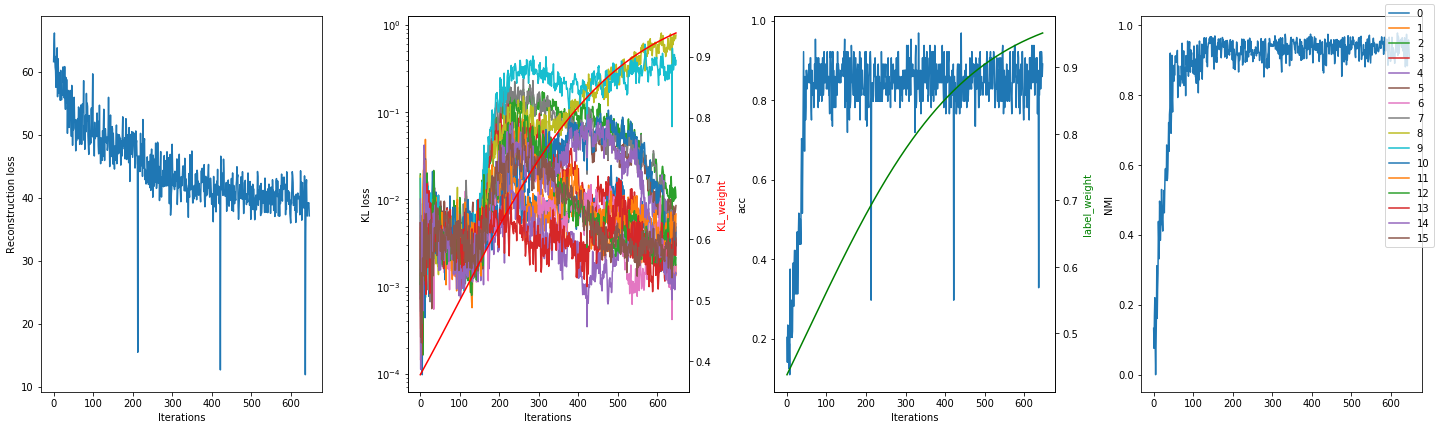

In [12]:
fig, axarr = plt.subplots(1,4, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['NLL_hist']
KL_hist  = run['KL_hist' ]
NMI_hist = run['NMI_hist']
acc_hist = run['acc_hist']
t = np.array(range(len(NLL_hist)))

from train import anneal_fn
anneal_fn = np.vectorize(anneal_fn)
KL_weight = anneal_fn(args.anneal_function, t, args.k1, args.x1, args.m1)
label_weight = anneal_fn(args.anneal_function, t, args.k2, args.x2, args.m2)

KL_hist = np.array(KL_hist)
axarr[0].plot(t, NLL_hist )
for i in range(args.latent_size):
    axarr[1].semilogy(t, KL_hist[:,i], label=i)
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')
axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')
axarr[3].plot(t, NMI_hist)

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax1bis.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
ax2bis.set_ylabel('label_weight', color='green')
axarr[3].set_ylabel('NMI')

fig.legend()
fig.tight_layout()
plt.show()

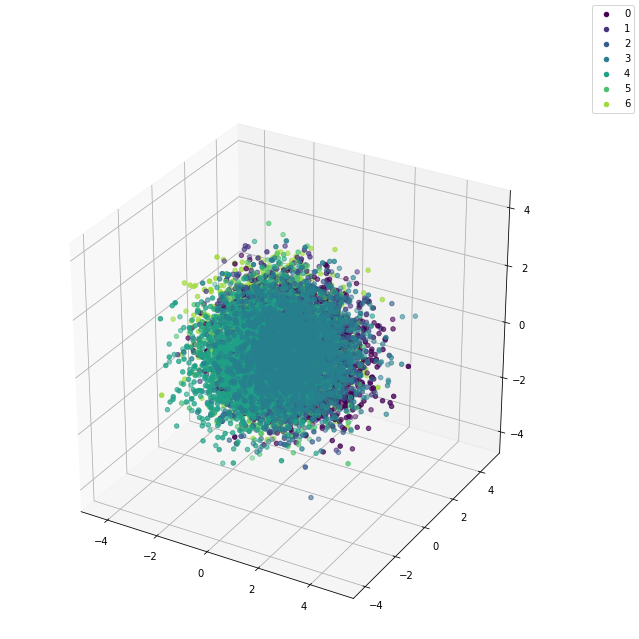

In [81]:
n_per_intent = 2000

latent = run['latent']
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

# Embeddings

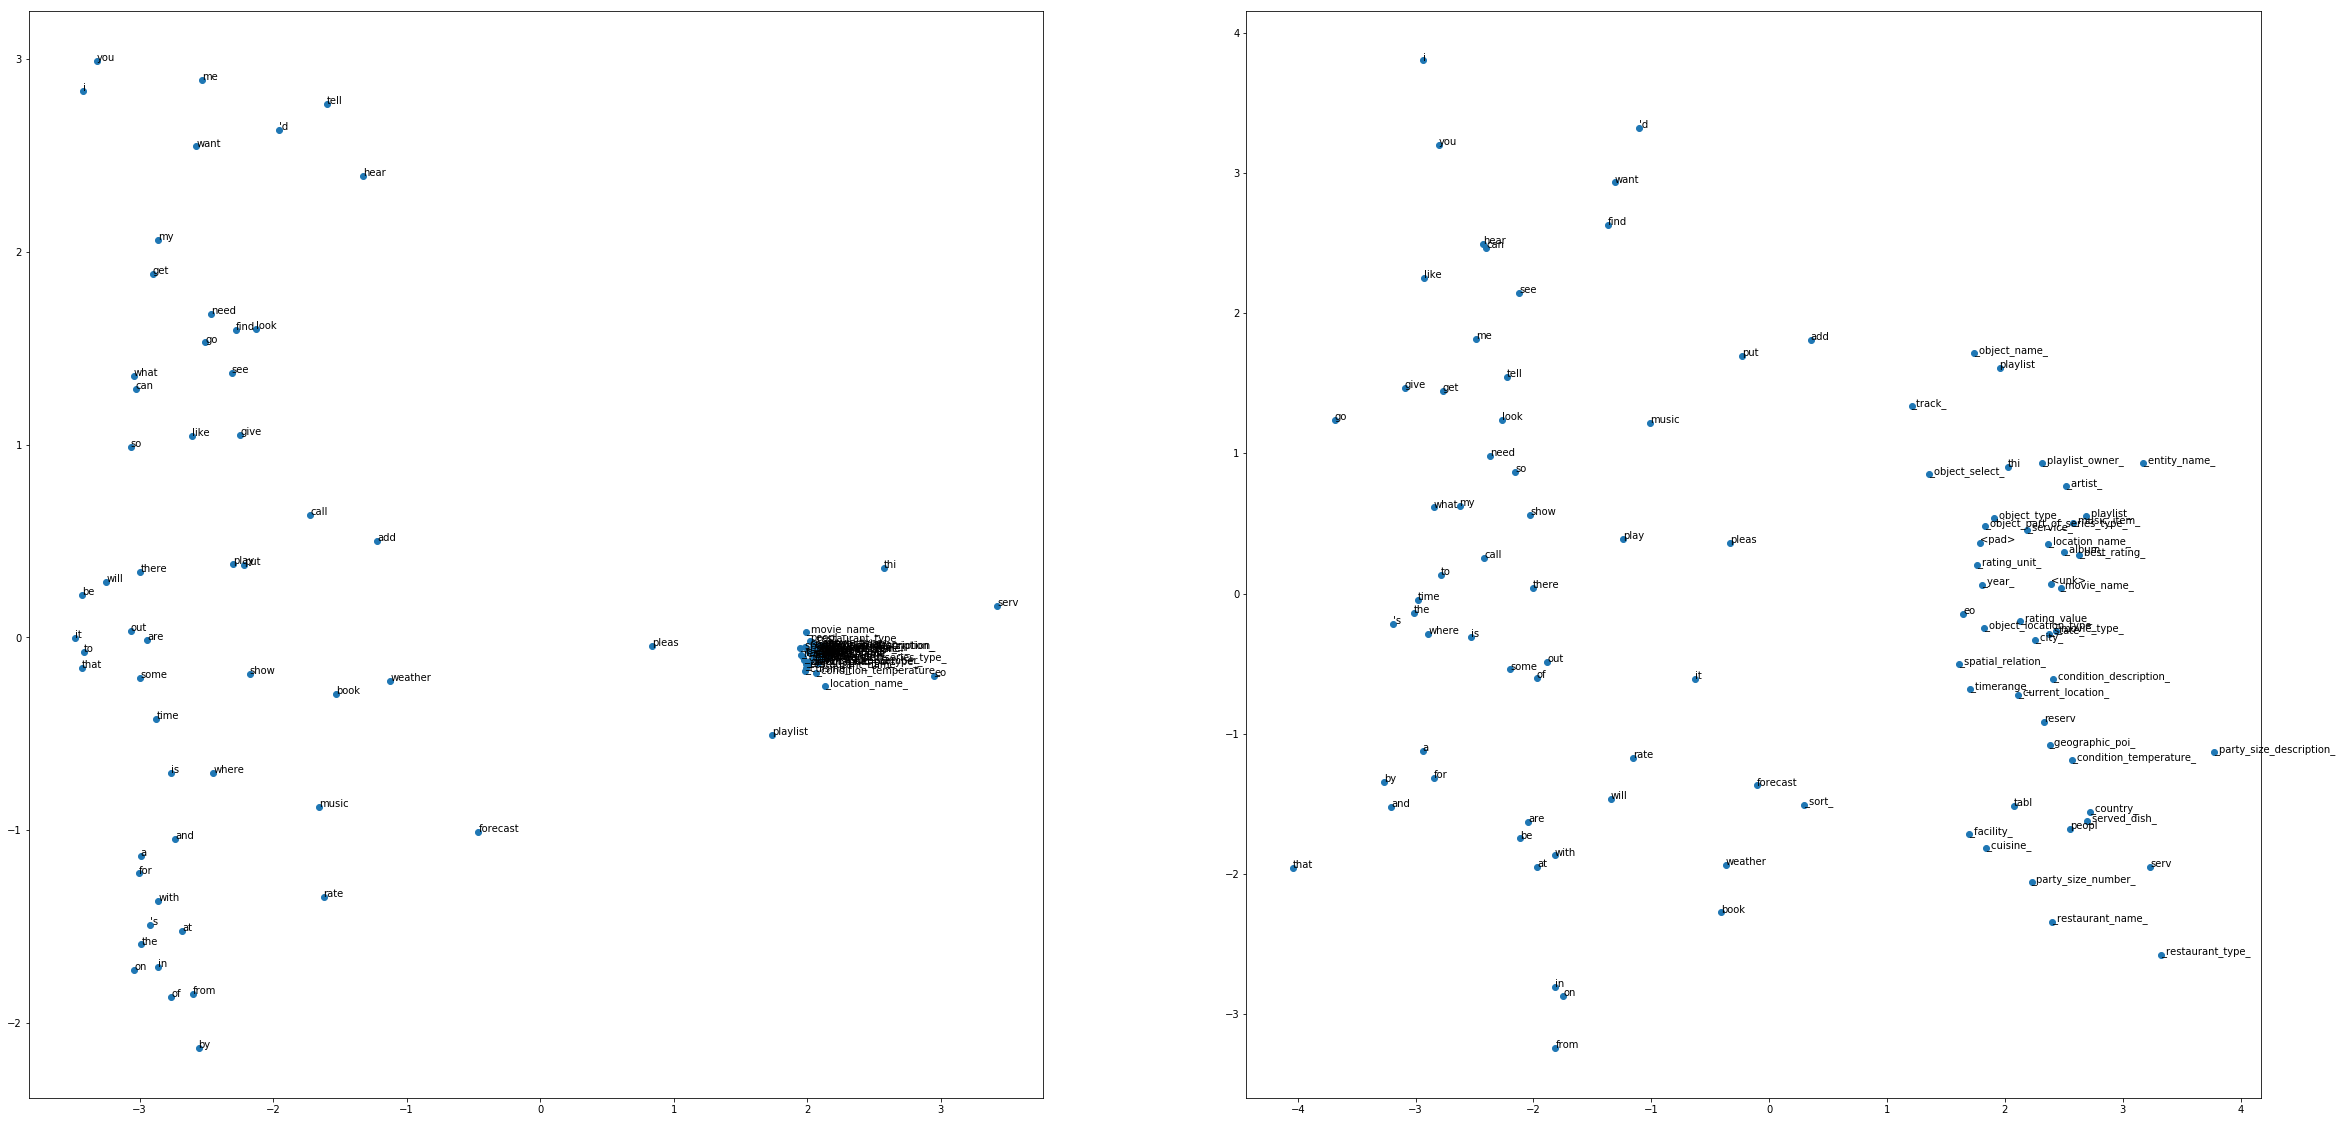

In [41]:
n_start = 0
n_end = 100
words = run['i2w']

fig, axarr = plt.subplots(1, 2, figsize=(40,20))
axarr = axarr.flatten()

from sklearn.decomposition import PCA
for ax, stage in enumerate(['before', 'after']):
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors)
    axarr[ax].scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        axarr[ax].annotate(word,xy=(proj[i,0], proj[i,1]))

# Trajectories in latent space

In [20]:
from embedding import Datasets
from model import CVAE
from utils import to_device, interpolate, idx2word

run = torch.load('run.pyT')
args = run['args']

datadir = os.path.join('./data', args.dataset)
train_path = os.path.join(datadir, 'train.csv')
validate_path = os.path.join(datadir, 'validate.csv')
datasets = Datasets(train_path=os.path.join(train_path), valid_path=os.path.join(validate_path), emb_dim=args.emb_dim, tokenizer=args.tokenizer)

if args.input_type=='delexicalised':
    print('embedding the slots with %s averaging' %args.slot_averaging)
    datasets.embed_slots(args.slot_averaging)

vocab = datasets.TEXT.vocab if args.input_type=='utterance' else datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
i2int = datasets.INTENT.vocab.itos
int2i = datasets.INTENT.vocab.stoi
n_classes = len(i2int)
sos_idx = w2i['SOS']
eos_idx = w2i['EOS']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

model = CVAE(
        vocab_size=len(i2w),
        max_sequence_length=args.max_sequence_length,
        sos_idx=sos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        unk_idx=unk_idx,
        embedding_size=args.emb_dim,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        z_size=args.latent_size,
        n_classes=n_classes,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,
        temperature=args.temperature
    )

state_dict = torch.load(args.save_model)
if state_dict['embedding.weight'].size(0) != model.embedding.weight.size(0): # vocab changed
    state_dict['embedding.weight'] = vocab.vectors
    state_dict['outputs2vocab.weight'] = torch.randn(len(i2w), args.hidden_size*model.hidden_factor)
    state_dict['outputs2vocab.bias'] = torch.randn(len(i2w))
model.load_state_dict(state_dict)

print('BLEU : ',run['bleu_scores'])
print('Diversity : ',run['diversity'])

embedding the slots with micro averaging
BLEU :  {'GetWeather': 0.6752136752136753, 'PlayMusic': 0.48867064308240776, 'BookRestaurant': 0.5891203703703703, 'SearchScreeningEvent': 0.8126601225285436, 'RateBook': 0.7185185185185184, 'SearchCreativeWork': 0.6499189658391954, 'AddToPlaylist': 0.8843454790823211, 'average': 0.6883496820907188}
Diversity :  0.3168685927306617


In [39]:
vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0540, -0.3618,  0.1093,  ..., -1.1465, -0.6180, -0.3259],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4821, -0.1325,  0.2281,  ...,  0.1610,  0.0099,  0.4094],
        [ 0.5548,  0.4931,  0.7383,  ..., -1.4376,  0.0075,  0.1910]])

## Vary the continuous variable

In [24]:
intent = 2
interp_dim = 8
print(i2int[intent] + '\n')

#z1 = torch.randn([args.latent_size]).numpy()
#z2 = torch.randn([args.latent_size]).numpy()
z1 = torch.zeros([args.latent_size]).numpy()
z2 = torch.zeros([args.latent_size]).numpy()
z1[interp_dim] = -1
z2[interp_dim] = +1
z = to_device(torch.from_numpy(interpolate(start=z1, end=z2, steps=10)).float())
batch_size=z.size(0)

y_onehot = torch.zeros(batch_size, model.n_classes)
y = torch.LongTensor(batch_size,1).fill_(intent)
y_onehot.scatter_(1, y, 1)
samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

print('-------INTERPOLATION-------')
print(*idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')

BookRestaurant

-------INTERPOLATION-------
so book book spot reserv _party_size_number_ peopl peopl
so book book spot book _party_size_number_ peopl peopl
so book book spot book _party_size_number_ _party_size_number_ peopl
so book book spot book _party_size_number_ _party_size_number_ peopl
so book want tabl book _party_size_number_ _party_size_number_ peopl
so book want tabl book book _party_size_number_ peopl
so book want tabl book book _party_size_number_ peopl
so book want tabl book book _party_size_number_ peopl
so book want book book book eat _party_size_number_
so book 'd tabl book book eat _party_size_number_
so book 'd tabl book book eat _party_size_number_
so book 'd tabl book book eat _party_size_number_


## Vary the discrete variable

In [25]:
z = torch.randn(model.n_classes,args.latent_size)

y_onehot = torch.zeros(model.n_classes, model.n_classes)
for i in range(model.n_classes):
    y_onehot[i,i] = 1

samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

for intent, sentence in enumerate(idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])):
    print(i2int[intent])
    print(sentence + '\n')

GetWeather
so what it be _condition_description_ _condition_description_ _condition_temperature_ _current_location_

PlayMusic
so what want hear hear hear hear hear

BookRestaurant
so book want book book book book _restaurant_name_

SearchScreeningEvent
so what 'd are watch watch watch watch

RateBook
so rate _object_select_ _object_select_ _rating_value_ _rating_value_ _best_rating_ _best_rating_

SearchCreativeWork
so play _track_ music music music music music

AddToPlaylist
so add _entity_name_ _playlist_owner_ _playlist_owner_ _playlist_owner_ playlist playlist



In [34]:
import torch
import numpy as np
target = torch.arange(0,5*64).view(64,-1)
bow = torch.randn((64,500))

loss = 0
for b, t in zip(bow, target):
    loss += torch.sum(b[t])
print(loss)
x = bow[:,target]
print(torch.einsum('iik->',(x)))
    #print(np.sum([b[idx].numpy() for idx in t]))

tensor(1.4885)
tensor(1.4885)
